# Twitter Sentiment Analysis

Python notebook ini dibuat untuk melakukan *educational experiments* tentang bagaimana sentimen orang tentang topik tertentu bicarakan di media sosial Twitter.

Library python yang digunakan adalah **Tweepy** dan sebuah **Twitter developer account** untuk mengakses Twitter API dengan lebih mudah.

In [554]:
!pip install textblob --upgrade
!pip install tweepy --upgrade
!pip install pycountry
!pip install langdetect

In [555]:
# import libraries

import os
import sys
import re
import string
import tweepy
from textblob import TextBlob
from langdetect import detect

# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Step - 1: Setup Twitter API

Pada notebook ini menggunakan data yang di-*retrieve* dari Twitter database melalui Twitter API v2. Untuk alasan privasi `bearer_token` tidak dimasukkan di branch ini

In [556]:
# Authentication
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAMeoYQEAAAAAACcMEkkweq9FUU5bOO7%2Fsej4B5M%3DITWB2hpzntRwHvmi2swgDknfaQKs7GVGQluXXVTXpN9QWc37ei'
client = tweepy.Client(bearer_token = bearer_token)

In [557]:
nltk.download('vader_lexicon')
def percentage(part, whole):
  return 100 * float(part)/float(whole)

# Geting tweets by keyword
# For this case we use #metaverse for the keyowrd, you can change it
tweets = client.search_recent_tweets(query='metaverse', max_results=100)

output = []

for tweet in tweets.data:
  # get tweet id
  id = tweet.id

  # get tweet text
  text = tweet.text

  # build polarity base on tweet text
  analysis = TextBlob(tweet.text)
  score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
  positive = score['pos']
  negative = score['neg']
  neutral = score['neu']
  comp = score['compound']
  polarity = analysis.sentiment.polarity

  target = 0
  if positive > negative:
    target = 4
  
  elif negative > positive:
    target = 0
  
  elif positive == neutral:
    target = 2

  line = {
      'id': id,
      'text': text,
      'positive': percentage(positive, 100),
      'negative': percentage(negative, 100),
      'neutral': percentage(neutral, 100),
      'polarity': percentage(polarity, 100),
      'target': target,
  }
  output.append(line)
  
df = pd.DataFrame(output)
df.to_csv('dataset.csv')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Step - 2: Exploratory Data Analysis (EDA)

 Melakukan EDA untuk mendapatkan problem statement sebelum training model

In [558]:
# show top 5 records of data
df.head()

,id,text,positive,negative,neutral,polarity,target
0,1485193940890718213,RT @plutoniansgame: Tomorrow we will begin to ...,0.205,0.000,0.795,-0.012500,4
1,1485193939435274245,RT @gems_1000: #BSC #BSCGem \nThis one is a bo...,0.000,0.113,0.887,0.000000,0
2,1485193938848071681,RT @vtmetaverse: VT Token Promotional Sale #Wh...,0.221,0.000,0.779,0.136364,4
3,1485193937103257604,RT @cryptohorsegame: Our Whitelist contest is ...,0.180,0.072,0.748,0.625000,4
4,1485193936062885889,RT @TelegramTycoon: Decentraland (MANA) Airdro...,0.000,0.000,1.000,0.000000,0


In [559]:
# show column info
df.columns

Index(['id', 'text', 'positive', 'negative', 'neutral', 'polarity', 'target'], dtype='object')

In [560]:
# show amount of data
print('length of data is', len(df))

length of data is 100


In [561]:
# show shape of data
df.shape

(100, 7)

In [562]:
# show dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        100 non-null    int64  
 1   text      100 non-null    object 
 2   positive  100 non-null    float64
 3   negative  100 non-null    float64
 4   neutral   100 non-null    float64
 5   polarity  100 non-null    float64
 6   target    100 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.6+ KB


In [563]:
# show data types
df.dtypes

id            int64
text         object
positive    float64
negative    float64
neutral     float64
polarity    float64
target        int64
dtype: object

In [564]:
# checking null values
np.sum(df.isnull().any(axis = 1))

0

In [565]:
# checking rows and columns
print('Count of columns in the data is: ', len(df.columns))
print('Count of rows in the data is: ', len(df))

Count of columns in the data is:  7
Count of rows in the data is:  100


In [566]:
# checking unique target values
df['target'].unique()

array([4, 0])

In [567]:
# checking number of target values
df['target'].nunique()

2

# Step - 3: Data Visualization of Target Variables

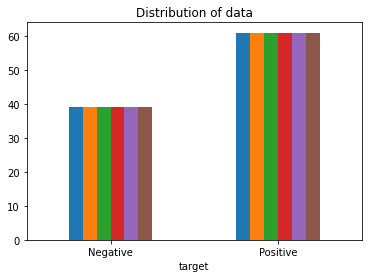

In [568]:
# ploting the distribution of dataset
ax = df.groupby('target').count().plot(kind = 'bar', title = 'Distribution of data', legend = False, )
ax.set_xticklabels(['Negative', 'Positive'], rotation = 0)

# storing data in a list
text, sentiment = list(df['text']), list(df['target'])

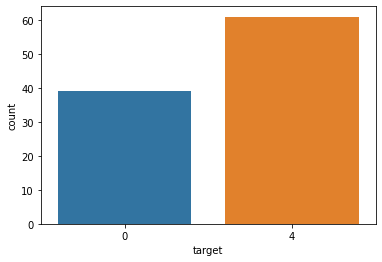

In [569]:
import seaborn as sns
sns.countplot(x = 'target', data = df)

# Step - 4: Data Preprocessing

Melakukan preprocessing data untuk menghapus stopwords dan emoji pada tweet

In [570]:
# selecting text and target column for further analysis
data = df[['text', 'target']]

In [571]:
# Replace 1 for positive target, so now 0 for negative and 1 for positive
data['target'] = data['target'].replace(4, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [572]:
data['target'].unique()

array([1, 0])

In [573]:
# separating positive and negative tweets
data_positive = data[data['target'] == 1]
data_negative = data[data['target'] == 0]

In [574]:
# combine positive and negative tweets
dataset = pd.concat([data_positive, data_negative])

In [575]:
# convert tweet to lowercase
dataset['text'] = dataset['text'].str.lower()
dataset['text'].tail()

92    rt @ibaxnetwork: go on! \nhttps://t.co/nephh1d...
96    rt @ralvero: 🚨presale alert🚨\n@metaraids\n\n🗓2...
97    #bsc #bscgem \nthis one is a bomb  $sugar\n\nb...
98    i just joined the #metafluence ido whitelist o...
99    #bsc #solana #mtk #metakings #metaverse  @lozo...
Name: text, dtype: object

In [576]:
#define stopwords (in english)
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [577]:
# cleaning stopwords from tweet
STOPWORDS = set(stopwordlist)

def cleaning_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].tail()

92    rt @ibaxnetwork: go on! https://t.co/nephh1dup...
96    rt @ralvero: 🚨presale alert🚨 @metaraids 🗓23rd ...
97    #bsc #bscgem one bomb $sugar bottom 💹 way up. ...
98    joined #metafluence ido whitelist #metavpad + ...
99    #bsc #solana #mtk #metakings #metaverse @lozov...
Name: text, dtype: object

In [578]:
# cleaning punctuations from tweet
import string
punctuation_list = string.punctuation

def cleaning_punctuation(text):
  translator = str.maketrans('', '', punctuation_list)
  return text.translate(translator)

dataset['text'] = dataset['text'].apply(lambda text: cleaning_punctuation(text))
dataset['text'].tail()

92    rt ibaxnetwork go on httpstconephh1dupv 📢📢📢📢📢📢...
96    rt ralvero 🚨presale alert🚨 metaraids 🗓23rd jan...
97    bsc bscgem one bomb sugar bottom 💹 way up ape ...
98    joined metafluence ido whitelist metavpad  bsc...
99    bsc solana mtk metakings metaverse lozova3005 ...
Name: text, dtype: object

In [579]:
# cleaning repeating characters from tweet
def cleaning_repeating_char(text):
  return re.sub(r'(.)1+', r'1', text)

dataset['text'] = dataset['text'].apply(lambda text: cleaning_repeating_char(text))
dataset['text'].tail()

92    rt ibaxnetwork go on httpstconeph1dupv 📢📢📢📢📢📢📢...
96    rt ralvero 🚨presale alert🚨 metaraids 🗓23rd jan...
97    bsc bscgem one bomb sugar bottom 💹 way up ape ...
98    joined metafluence ido whitelist metavpad  bsc...
99    bsc solana mtk metakings metaverse lozova3005 ...
Name: text, dtype: object

In [580]:
# cleaning urls from tweet
def cleaning_url(text):
  return re.sub('((www.[^s]+)|(https?://[^s]+))', ' ', text)

dataset['text'] = dataset['text'].apply(lambda text: cleaning_url(text))
dataset['text'].tail()

92    rt ibaxnetwork go on httpstconeph1dupv 📢📢📢📢📢📢📢...
96    rt ralvero 🚨presale alert🚨 metaraids 🗓23rd jan...
97    bsc bscgem one bomb sugar bottom 💹 way up ape ...
98    joined metafluence ido whitelist metavpad  bsc...
99    bsc solana mtk metakings metaverse lozova3005 ...
Name: text, dtype: object

In [581]:
# cleaning numberic characters from tweet
def cleaning_numeric(text):
  return re.sub('[0-9]+', '', text)

dataset['text'] = dataset['text'].apply(lambda text: cleaning_numeric(text))
dataset['text'].tail()

92    rt ibaxnetwork go on httpstconephdupv 📢📢📢📢📢📢📢 ...
96    rt ralvero 🚨presale alert🚨 metaraids 🗓rd janua...
97    bsc bscgem one bomb sugar bottom 💹 way up ape ...
98    joined metafluence ido whitelist metavpad  bsc...
99    bsc solana mtk metakings metaverse lozova hami...
Name: text, dtype: object

In [582]:
#get tokenization from each tweets
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

0                                  [w]
2                            [w, w, w]
3                                  [w]
5    [w, w, w, w, w, w, w, w, w, w, w]
6                                  [w]
Name: text, dtype: object

In [583]:
#Apply stemming
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
    
dataset['text']= dataset['text'].apply(lambda text: stemming_on_text(text))
dataset['text'].head()

0                                  [w]
2                            [w, w, w]
3                                  [w]
5    [w, w, w, w, w, w, w, w, w, w, w]
6                                  [w]
Name: text, dtype: object

In [584]:
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
    
dataset['text'] = dataset['text'].apply(lambda text: lemmatizer_on_text(text))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                  [w]
2                            [w, w, w]
3                                  [w]
5    [w, w, w, w, w, w, w, w, w, w, w]
6                                  [w]
Name: text, dtype: object

In [585]:
# separating input and feature label
X = data.text
y = data.target

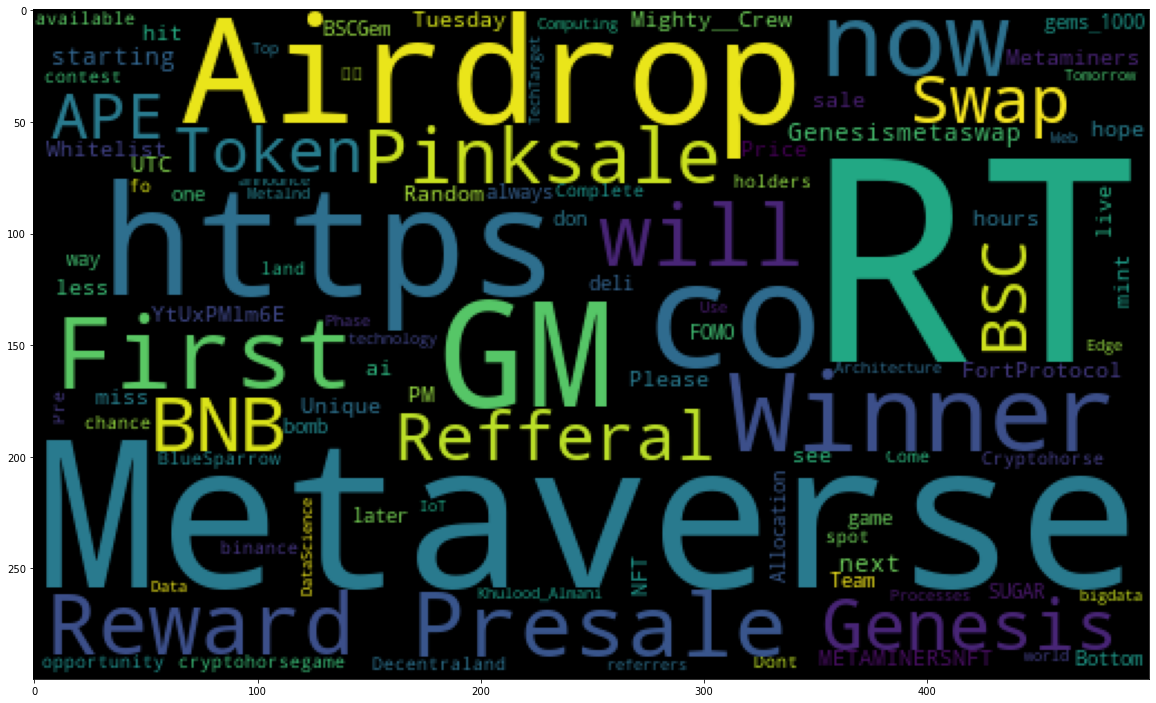

In [586]:
# plot word cloud for negative tweets
data_negative = data['text'][:50]
plt.figure(figsize = (20, 20))
word_cloud = WordCloud(max_words=100, width=500, height=300, collocations=False).generate(" ".join(data_negative))

plt.imshow(word_cloud)

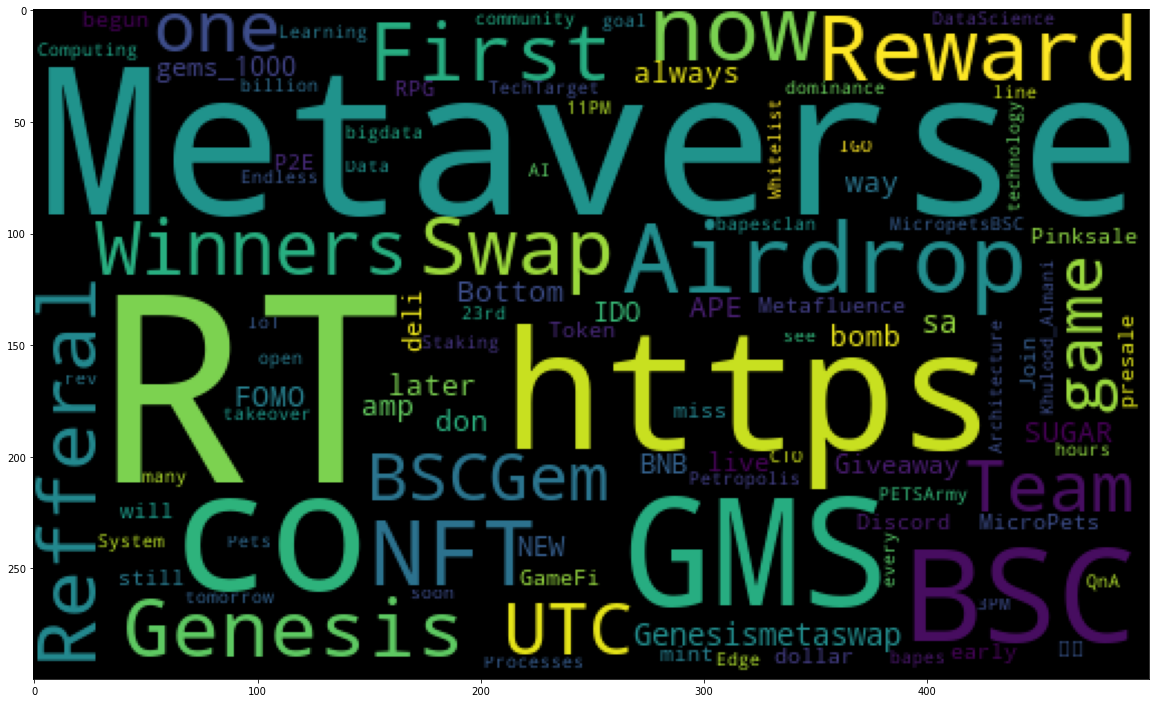

In [587]:
# plot word cloud for positive tweets
data_negative = data['text'][50:]
plt.figure(figsize = (20, 20))
word_cloud = WordCloud(max_words=100, width=500, height=300, collocations=False).generate(" ".join(data_negative))

plt.imshow(word_cloud)

# Step - 5: Build Model and Train

In [588]:
# splitting data into training and test subset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 1)

In [589]:
# fit the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  50


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [590]:
# transform dataset using TF-IDF Vectorizer
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [591]:
# function for model evaluation
def model_evaluate(model):
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))
  
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative', 'Positive']
  group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



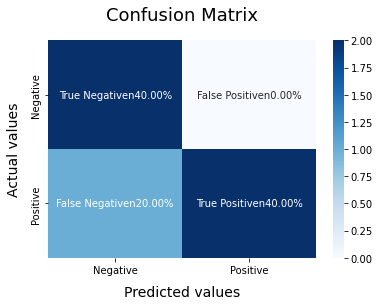

In [592]:
# build model using bernouli naive-bayes
BNBModel = BernoulliNB()
BNBModel.fit(X_train, y_train)
model_evaluate(BNBModel)
y_pred1 = BNBModel.predict(X_test)

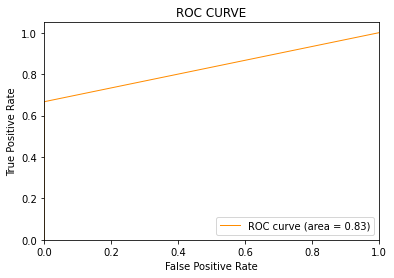

In [593]:
# bernoulli naive bayes's ROC-AUC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



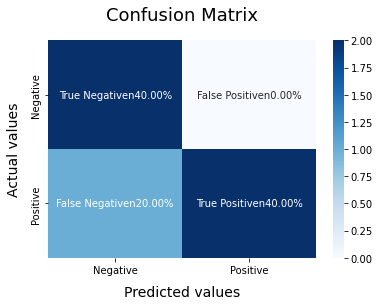

In [594]:
# build model using support vector classifier
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

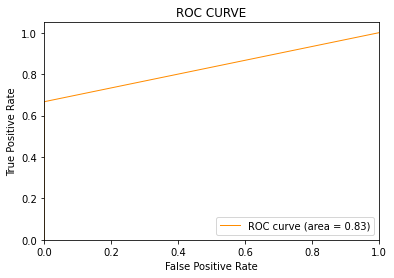

In [595]:
# support vector machine's ROC-AUC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



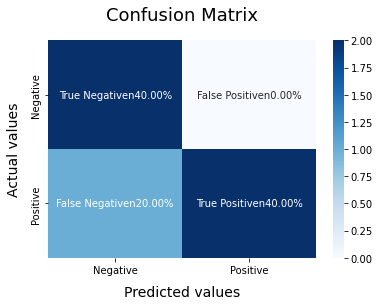

In [596]:
#Model using logistic regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

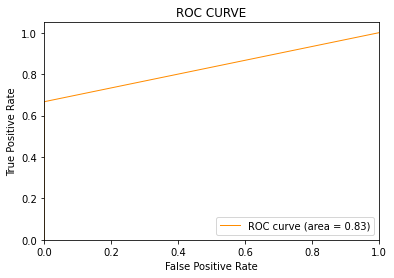

In [597]:
# logistic regression ROC-AUC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()